# TP 1 - Algorithme de r√©tro-propagation de l‚Äôerreur

**L‚Äôobjectif de cette premi√®re s√©ance de travaux pratiques est de vous faire impl√©menter par vous m√™me l‚Äôapprentissage de r√©seaux de neurones simples.**
Cettre prise en main sera tr√®s formatrice pour utiliser des mod√®les plus √©volu√©s, et comprendre le fonctionnement des libaries (comme Keras) o√π l‚Äôapprentissage est automatis√©.

On va travailler avec la base de donn√©es image MNIST, constitu√©e d‚Äôimages de
caract√®res manuscrits (60000 images en apprentissage, 10000 en test).

Voici un bout de code pour r√©cup√©rer les donn√©es  :

## Exercice 0 : visualisation de quelques images de la base
<dl style='margin: 20px 0;'>
<dt>Nous commencerons par afficher les 200 premi√®res images de la base d‚Äôapprentissage.</dt>
<dd>
    
- √âcrire un script qui r√©cup√®re les donn√©es avec le code pr√©c√©dent.  
- Compl√©ter pour permettre l‚Äôaffichage demand√© en utilisant le code suivant :  

In [2]:
!pip3 install -U tensorflow keras h5py scipy sklearn matplotlib pandas nltk pillow

  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2959 sha256=86a83169a11ce69a2c16ad4fec697b52b4caf5e7732fb40c85ce3f293415f85a
  Stored in directory: c:\users\mehdi\appdata\local\pip\cache\wheels\f8\e0\3d\9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn
  Attempting uninstall: h5py
    Found existing installation: h5py 3.6.0
    Uninstalling h5py-3.6.0:
      Successfully uninstalled h5py-3.6.0
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.0.1
    Uninstalling Pillow-9.0.1:
      Successfully uninstalled Pillow-9.0.1
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.2
    Uninstalling pandas-1.4.2:
      Successfully uninstalled pandas-1.4.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Unin

In [3]:
from keras.datasets import mnist
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

11490434/11490434 [==============================] - 7s 1us/step
60000 train samples
10000 test samples


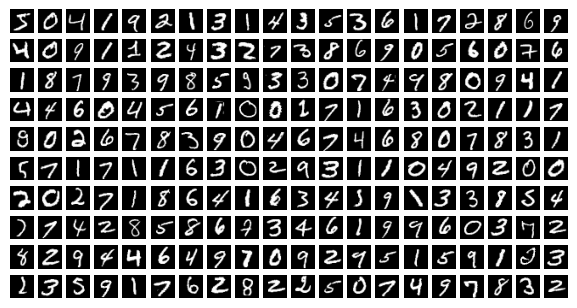

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.figure(figsize=(7.195, 3.841), dpi=100)
for i in range(200):
  plt.subplot(10,20,i+1)
  plt.imshow(X_train[i,:].reshape([28,28]), cmap='gray')
  plt.axis('off')
plt.show()

## Question :

Quel est l‚Äôespace dans lequel se trouvent les images ? Quel est sa taille ?

Les images sont des flotants, 28*28

## Exercice 1 : R√©gression Logistique

### Mod√®le de pr√©diction


<dl style='margin: 20px 0;'>
<dt>On va d‚Äôabord commencer par cr√©er un mod√®le de classification lin√©aire populaire, la r√©gression logistique.</dt>
<dd>
Ce mod√®le correspond √† un r√©seau de neurones √† une seule couche, qui va projeter le vecteur d‚Äôentr√©e $ \mathbf{x_i} $ pour une image MNIST
(taille $ 28^2=784 $) avec un vecteur de de param√®tres $ \mathbf{w_{c}} $ pour chaque classe (plus un biais $ b_c $).
Pour correspondre √† la matrice des donn√©es de l‚Äôexercice pr√©c√©dent, on consid√®re que chaque exemple $ \mathbf{x_i} $ est un vecteur ligne - taille (1,784).
En regroupant l‚Äôensemble des jeux de param√®tres $ \mathbf{w_{c}} $ pour les 10 classes dans une matrice $ \mathbf{W} $ (taille $ 784\times 10 $),
et les biais dans un vecteur $ \mathbf{b} $, on obtient un vecteur
$ \mathbf{\hat{s_i}} =\mathbf{x_i}  \mathbf{W}  + \mathbf{b} $ de taille (1,10).
Une fonction d‚Äôactivation de type soft-max sur $ \mathbf{\hat{y_i}} = $ `softmax` $ (\mathbf{s_i}) $ permet d‚Äôobtenir le vecteur de sortie pr√©dit par le mod√®le $ \mathbf{\hat{y_i}} $
- de taille (1,10) - qui repr√©sente la probabilit√© *a posteriori*
$ p(\mathbf{\hat{y_i}} | \mathbf{x_i}) $ pour chacune des 10 classes:

</dd>

</dl>


<a id='equation-softmax'></a>
$$
p(\hat{y_{c,i}} | \mathbf{x_i}) ) = \frac{e^{\langle \mathbf{x_i} ; \mathbf{w_{c}}\rangle + b_{c}}}{\sum\limits_{c'=1}^{10} e^{\langle \mathbf{x_i} ; \mathbf{w_{c'}}\rangle + b_{c'}}} \tag{1}
$$

Le sch√©ma ci-dessous illustre le mod√®le de r√©gression logistique avec un r√©seau de neurones.

<img src="http://cedric.cnam.fr/~thomen/cours/US330X/_images/LR.png" style="height:150px;" align="center">

- Quel est le nombre de param√®tres du mod√®le ? Justifier le calcul.  

### Formulation du probl√®me d‚Äôapprentissage

> Afin d‚Äôentra√Æner le r√©seau de neurones, on va comparer, pour chaque exemple d‚Äôapprentissage, la sortie pr√©dite $ \mathbf{\hat{y_i}} $ par le r√©seau
(√©quation [(1)](#equation-softmax)) pour l‚Äôimage $ \mathbf{x_i} $, avec la sortie
r√©elle $ \mathbf{y_i^*} $ issue de la supervision qui correspond √† la cat√©gorie de l‚Äôimage $ \mathbf{x_i} $:
on utilisera en encodage de type ¬´¬†one-hot¬†¬ª pour $ \mathbf{y_i^*} $, *i.e.* :



<a id='equation-one-hot'></a>
$$
y_{c,i}^* =
 \begin{cases}
   1 & \text{si c correspond √† l'indice de la classe de } \mathbf{x_i}  \\
   0 & \text{sinon}
 \end{cases} \tag{2}
$$

Pour mesurer l‚Äôerreur de pr√©diction, on utilisera une fonction de co√ªt de type entropie crois√©e (¬´¬†cross-entropy¬†¬ª) entre $ \mathbf{\hat{y_i}} $ et $ \mathbf{y_i^*} $
(l‚Äôentropie crois√©e est li√© √† la divergence de Kullback-Leiber, qui mesure une dissimilarit√© entre distributions de probabilit√©s) :
$ \mathcal{L}(\mathbf{\hat{y_i}}, \mathbf{y_i^*}) = -\sum\limits_{c=1}^{10} y_{c,i}^* log(\hat{y}_{c,i}) = - log(\hat{y}_{c^*,i}) $, o√π $ c^* $ correspond √† l‚Äôindice de la classe donn√© par la supervision pour l‚Äôimage $ \mathbf{x_i} $.

La fonction de co√ªt finale consistera √† moyenner l‚Äôentropie crois√©e sur l‚Äôensemble de la base d‚Äôapprentissage $ \mathcal{D} $ consistu√©e de $ N=60000 $ images :


<a id='equation-ce'></a>
$$
\mathcal{L}_{\mathbf{W},\mathbf{b}}(\mathcal{D})  = - \frac{1}{N}\sum_{i=1}^{N} log(\hat{y}_{c^*,i}) \tag{3}
$$

### Question :

La fonction de co√ªt de l‚ÄôEq. [(3)](#equation-ce) est-elle convexe par rapports aux param√®tres $ \mathbf{W} $, $ \mathbf{b} $ du mod√®le ? Avec un pas de gradient bien choisi, peut-on assurer la convergence vers le minimum  global de la solution ?

### Optimisation du mod√®le

Afin d‚Äôoptimiser les param√®tres $ \mathbf{W} $ et $ \mathbf{b} $ du mod√®le de r√©gression logistique par descente de gradient, on va utiliser la r√®gle des d√©riv√©es cha√Æn√©es (chain rule) :

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}} =  \frac{1}{N}\sum_{i=1}^{N} \frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y_i}}}  \frac{\partial \mathbf{\hat{y_i}}}{\partial \mathbf{s_i}} \frac{\partial \mathbf{s_i}}{\partial \mathbf{W}}
$$

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{b}} =  \frac{1}{N}\sum_{i=1}^{N} \frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y_i}}}  \frac{\partial \mathbf{\hat{y_i}}}{\partial \mathbf{s_i}} \frac{\partial \mathbf{s_i}}{\partial \mathbf{b}}
$$

### Montrer que :

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{s_i}} = \mathbf{\delta^y_i}  =\frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y_i}}}  \frac{\partial \mathbf{\hat{y_i}}}{\partial \mathbf{s_i}} = \mathbf{\hat{y_i}} - \mathbf{y_i^*}
$$

### En d√©duire que les gradients de $ \mathcal{L} $ par rapport aux param√®tres du mod√®le s‚Äô√©crivent :


<a id='equation-gradientw-LR'></a>
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}} = \frac{1}{N} \mathbf{X}^T (\mathbf{\hat{Y}} - \mathbf{Y^*}) = \frac{1}{N} \mathbf{X}^T \mathbf{\Delta^y} \tag{4}
$$


<a id='equation-gradientb-LR'></a>
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{b}} = \frac{1}{N}\sum_{i=1}^{N}(\mathbf{\hat{y_i}} - \mathbf{y_i^*}) \tag{5}
$$

O√π  $ \mathbf{X} $ est la matrice des donn√©es (taille $ 60000\times 784 $), $ \mathbf{\hat{Y}} $ est la matrice des labels pr√©dits sur l‚Äôensemble de la base d‚Äôapprentissage (taille $ 60000\times 10 $)
et $ \mathbf{Y^*} $ est la matrice des labels donn√©e issue de la supervision (¬´¬†ground truth¬†¬ª, taille $ 60000\times 10 $), et $ \mathbf{\Delta^y}=\mathbf{\hat{Y}}-\mathbf{Y^*} $.

### Impl√©mentation de l‚Äôapprentissage

Les gradients aux √©quations [(4)](#equation-gradientw-LR) et [(5)](#equation-gradientb-LR) s‚Äô√©crivent sous forme ¬´¬†vectorielle¬†¬ª, ce qui va rendre les calculs efficaces avec des librairies de calculs scientifique comme `numpy`. Apr√®s calcul du gradient, les param√®tres
seront mis √† jour de la mani√®re suivante :


<a id='equation-gradientupdatew'></a>
$$
\mathbf{W}^{(t+1)} = \mathbf{W}^{(t)} - \eta \frac{\partial \mathcal{L}}{\partial \mathbf{W}} \tag{6}
$$


<a id='equation-gradientupdateb'></a>
$$
\mathbf{b}^{(t+1)} = \mathbf{b}^{(t)} - \eta \frac{\partial \mathcal{L}}{\partial \mathbf{b}} \tag{7}
$$

o√π $ \eta $ est le pas de gradient (learning rate).

Pour impl√©menter l‚Äôalgorithme d‚Äôapprentissage, on utuilisera une descente de gradient stochastique, c‚Äôest √† dire que les gradients aux √©quations [(4)](#equation-gradientw-LR) et [(5)](#equation-gradientb-LR)  ne seront pas calcul√©s
sur l‚Äôensemble des $ N=60000 $ images d‚Äôapprentissage, mais sur un sous ensemble appel√© **batch**. Cette technique permet une mise √† jour des param√®tres plus fr√©quente qu‚Äôavec une descente de gradient classique, et une convergence
plus rapide (au d√©triment d‚Äôun calcul de gradient approxim√©).

**On demande de mettre en place un script** `exo1.py` **qui impl√©mente l‚Äôalogorithme de r√©gression logistique sur la base MNIST.**

Apr√®s avoir charg√© les donn√©es (exercice 0), on utilisera le code suivant pour g√©n√©rer des labels au format
0-1 encoding - √©quation [(2)](#equation-one-hot).

In [24]:
from keras.utils import np_utils
K=10
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, K)
Y_test = np_utils.to_categorical(y_test, K)

**On pourra utiliser la fonction suivante pour calculer la fonction softmax sur chaque √©l√©ment de de la matrice de la projection lin√©raire (taille ùë°ùëè√ó10) :**

In [25]:
def softmax(X):
    # Input matrix X of size Nbxd - Output matrix of same size
    E = np.exp(X)
    return (E.T / np.sum(E,axis=1)).T

In [26]:
def forward (x,w,b) : 
    s= np.dot(x,w)+b
    y=softmax(s)
    return y 
def backward (x,y,eta,w,b,yc):
    N= batch_size 
    
    dw= (np.dot(x.T,yc-y))/N

    db= np.sum(yc-y)/N
    w=w-eta*dw
    b=b-eta*db
    return w, b
        

## On mettra alors en place un code dont le squellette est donn√© ci-dessous :

In [32]:
import numpy as np 
N = X_train.shape[0]
d = X_train.shape[1]
w = np.zeros((d,K))
b = np.zeros((1,K))
numEp = 20 # Number of epochs for gradient descent
eta = 1e-1 # Learning rate
batch_size = 100
nb_batches = int(float(N) / batch_size)
gradW = np.zeros((d,K))
gradb = np.zeros((1,K))

for epoch in range(numEp):
    for ex in range(nb_batches):
        # FORWARD PASS : compute prediction with current params for examples in batch
        yc=forward(X_train[ex*batch_size:(ex+1)*batch_size],w,b)
        w,b = backward (X_train[ex*batch_size:(ex+1)*batch_size],Y_train[ex*batch_size:(ex+1)*batch_size],eta,w,b,yc)
            
        # BACKWARD PASS :
        # 1) compute gradients for W and b
        # 2) update W and b parameters with gradient descent

Pour compl√©ter ce code, vous devez :

- Mettre en place une fonction `forward(batch, W, b)` qui va calculer la pr√©diction pour un batch de donn√©es. La fonction `forward` sera appel√©e pour chaque it√©ration de la double boucle pr√©c√©dente.  


> - Si on consid√®re un batch des donn√©es de taille $ tb\times 784 $, les param√®tres $ \mathbf{W} $ (taille $ 784\times 10 $) et $ \mathbf{b} $ (taille $ 1\times 10 $), la fonction `forward` renvoie la pr√©diction $ \mathbf{\hat{Y}} $ sur le batch (taille $ tb\times 10 $).    

- Compl√©ter le code pour la passe backward, consistant √†  :
  - Calculer les gradient comme indiqu√© aux √©quations [(4)](#equation-gradientw-LR) et [(5)](#equation-gradientb-LR).
  - Mettre √† jour les param√®tres par descente de gradient comme indiqu√© aux √©quations [(6)](#equation-gradientupdatew) et [(7)](#equation-gradientupdateb).  


Enfin vous pouvez utiliser la fonction `accuracy(W, b, images, labels)` fournie pour calculer le taux de bonne reconnaissance du mod√®le. Ceci permettra de mesurer l‚Äô√©volution des performances au cours des √©poques de l‚Äôalgorithme d‚Äôapprentissage, et sur la base de test une fois le mod√®le appris.

### Vous devez obtenir un score de l‚Äôordre de 92% sur la base de test pour ce mod√®le de r√©gression logistique.

In [35]:
def accuracy(W, b, images, labels):
  pred = forward(images, W,b )
  return np.where( pred.argmax(axis=1) != labels.argmax(axis=1) , 0.,1.).mean()*100.0

In [36]:
accuracy(w, b, X_test, Y_test)

92.13

## Exercice 2 : Perceptron multi-couches (MLP)

### L‚Äôobjectif de ce second exercice est d‚Äô√©tendre le mod√®le de r√©gression logistique afin de mettre en place des mod√®les de pr√©dictions plus riches.
**En particulier, on va s‚Äôint√©resser aux Perceptron multi-couches (Multi-Layer Percpetron, MLP)**. Contrairement √† la r√©gression logistique qui se limite √† des s√©parateurs lin√©aires,
le Perceptron permet l‚Äôapprentissage de fronti√®res de d√©cisions non lin√©aires, et constituent des approximateurs universels de fonctions.

L‚Äôobjectif de la s√©ance de travaux pratiques est de mettre en place le code pour effectuer des pr√©dictions et entra√Æner un Perceptron √† une couche cach√©e.

### Pr√©diction avec un Perceptron (Forward)

L‚Äôarchitecture du perpcetron √† une couche cach√©e est montr√©e √† la figure ci-dessous.

<img src="http://cedric.cnam.fr/~thomen/cours/US330X/_images/MLP.png" style="height:250px;" align="center">

Si on consid√®re les donn√©es de la base MNIST, chaque image est repr√©sent√©e par un vecteur de taille $ 28^2=784 $.
Le perpcetron va effecteur les diff√©rentes √©tape de transformation pour produire la pr√©diction finale, *i.e.* la cat√©gorie s√©mantique de l‚Äôimage :

- Une √©tape de projection lin√©aire, qui va projeter chaque image sur un vecteur de taille $ (1,L) $, *e.g.* $ L=100 $. En consid√©rant chaque exemple $ \mathbf{x_i} $ est un vecteur ligne - taille $ (1,784) $ - la projection lin√©aire peut √™tre repr√©sent√©e par la matrice $ \mathbf{W^h} $ (taille $ (784, L) $), et le vecteur de biais $ \mathbf{b^h} $ (taille $ (1, L) $) : $ \mathbf{\hat{u_i}} =\mathbf{x_i}  \mathbf{W^h}  + \mathbf{b^h} $.  


> - Une √©tape de non lin√©arit√©, *e.g.* de type sigmo√Øde :  $ \forall j \in  \left\lbrace 1; L \right\rbrace  ~ h_{i,j} = \frac{1}{1+exp(-u_{i,j})} $  



- Une seconde √©tape de projection lin√©aire, qui va projeter le vecteur latent de taille $ (1,L) $ sur un vecteur de taille $ (1,K)=10 $ (nombre de classes). Cette op√©ration de projection lin√©aire sera repr√©sent√©e par la matrice $ \mathbf{W^y} $ (taille $ (L, K) $), et le vecteur de biais $ \mathbf{b^y} $ (taille $ (1, K) $) : $ \mathbf{\hat{v_i}} =\mathbf{h_i}  \mathbf{W^y}  + \mathbf{b^y} $.  


> - Une √©tape de non lin√©arit√© de type soft-max vue la semaine pr√©c√©dente pour la r√©gression logistique : $ \forall j \in  \left\lbrace 1; K \right\rbrace  ~ y_{i,j} = \frac{exp(v_{i,j})}{\sum\limits_{i=1}^K exp(v_{i,k})} $  



**On demande de mettre en place un script** `mlp.py` **qui impl√©mente l‚Äôalogorithme du Percpetron sur la base MNIST.**


<dl style='margin: 20px 0;'>
<dt>L‚Äôalgorithme reprendra le squelette du code de la r√©gression logistique. Pour adapter ce code pour le Perceptron pour la partie pr√©diction,  vous devez :</dt>
<dd>
- Modifier la fonction de pr√©diction, afin disposer la fonction `forward(batch, Wh, bh, Wy, by)` qui reverra √† la fois la pr√©diction pour le batch ainsi que la matrice des couches latentes.  


> - Si on consid√®re un batch des donn√©es de taille $ t_b\times 784 $, les param√®tres $ \mathbf{W^h} $ (taille $ 784\times L $), $ \mathbf{b^h} $ (taille $ 1\times L $), $ \mathbf{W^y} $ (taille $ L\times K $) et $ \mathbf{b^y} $ (taille $ 1\times K $), la fonction `forward` renvoie la pr√©diction $ \mathbf{\hat{Y}} $ sur le batch (taille $ t_b\times K $) et la matrice de variables latentes (taille $ t_b\times L $).  



</dd>

</dl>

In [ ]:
# Function forward pour le MLP
def forward(batch, Wh, bh, Wy, by):                 
    latent = 0
    res = 0
    return latent, res

In [ ]:
# Calcul de l'accuracy avec le MLP
def accuracy(batch, labels,Wh, bh, Wy, by):
   latent, pred = forward(batch, Wh, bh, Wy, by)  
   return np.where( pred.argmax(axis=1) != labels.argmax(axis=1) , 0.,1.).mean()*100.0

### Apprentissage du Perceptron (Backward)

Afin d‚Äôentra√Æner le Perceptron, on va utiliser l‚Äôalgorithme de r√©tro-propagation de l‚Äôerreur. On rappelle que pour chaque batch d‚Äôexemples, l‚Äôalgorithme va effectuer une passe `forward` (Exercice 1), permettant de calculer la pr√©diction du r√©seau.
Une fonction de co√ªt (ici l‚Äôentropie crois√©e) entre la sortie pr√©dite et la la sortie donn√©e par la supervision va permettre de calculer le gradient de l‚Äôerreur par rapport √† tous les param√®tres param√®tres du mod√®le, *i.e.* $ \mathbf{W^y} $ (taille $ (L, K) $), $ \mathbf{b^y} $ (taille $ (1, K) $), $ \mathbf{W^h} $ (taille $ (784, L) $), et $ \mathbf{b^h} $ (taille $ (1, L) $).

On rappelle les √©quation des gradients, effectu√©es depuis le haut vers le bas du r√©seau :

1. Mise √† jour de $ \mathbf{W^y} $ et $ \mathbf{b^y} $ :  


$$
\frac{\partial \mathcal{L}}{\partial \mathbf{v_i}} = \mathbf{\delta^y_i} = \mathbf{\hat{y_i}} - \mathbf{y_i^*}
$$


<a id='equation-gradientw'></a>
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W^y}} = \frac{1}{t_b}\mathbf{H}^T (\mathbf{\hat{Y}} - \mathbf{Y^*}) = \frac{1}{t_b} \mathbf{H}^T \mathbf{\Delta^y} \tag{8}
$$


<a id='equation-gradientb'></a>
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{b^y}} = \frac{1}{t_b}\sum_{i=1}^{t_b}(\mathbf{\hat{y_i}} - \mathbf{y_i^*}) \tag{9}
$$

O√π  $ \mathbf{H} $ est la matrice des couches cach√©es sur le batch (taille $ t_b\times L $), $ \mathbf{\hat{Y}} $ est la matrice des labels pr√©dits sur l‚Äôensemble de la base d‚Äôapprentissage (taille $ t_b\times K $)
et $ \mathbf{Y^*} $ est la matrice des labels donn√©e issue de la supervision (¬´¬†ground truth¬†¬ª, taille $ t_b\times K $), et $ \mathbf{\Delta^y}=\mathbf{\hat{Y}}-\mathbf{Y^*} $.

1. Mise √† jour de $ \mathbf{W^h} $ et $ \mathbf{b^h} $ :  


$$
\frac{\partial \mathcal{L}}{\partial \mathbf{u_i}} = \mathbf{\delta^h_i} = \mathbf{\delta^y_i} \mathbf{W^{y}}^T   \odot \sigma^{'}(\mathbf{u_i}) = \mathbf{\delta^y_i} \mathbf{W^{y}}^T \odot (\mathbf{h_i} \odot (1-\mathbf{h_i}))
$$

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W^h}} =  \frac{1}{t_b} \mathbf{X}^T \mathbf{\Delta^h}
$$

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{b^h}} = \frac{1}{t_b}\sum_{i=1}^{t_b}(\delta^h_i)
$$

O√π  $ \mathbf{X} $ est la matrice des donn√©es sur le batch (taille $ t_b\times 784 $), et $ \mathbf{\Delta^h} $ est la matrice des $ \delta^h_i $ sur le batch (taille $ t_b\times L $).

## Adapter la partie backward de l‚Äôalgorithme pour entra√Æner le Perceptron.
On Choisira un pas de gradient $ \eta=1.0 $ et 100 √©poques.

In [ ]:
d = X_train.shape[1] # dimension d'entr√©e (784)
N = X_train.shape[0] # nombre d'exemples d'apprentissage (60000)
L=100 # dimension de l'espace latent 

# Initialisation des poids : Gaussienne ou Glorot (voir ci-dessous)  
Wh = 0
bh = 0
Wy = 0
by = 0

# Hyper-param√®tres d'apprentissage
numEpochs = 50
eta = 1

batch_size = 100
nb_batches = int(float(N) / batch_size)

for it in range(numEpochs):
    for b in range(nb_batches):
        # FORWARD
        
        # BACKWARD 
        # Calcul de deltay = dE / dy~         
        # Calcul de gradWy = h^T * deltay - (LxN) * (NxK)  et gradby      
 
        # Calcul de  deltah   =dE / dh~ size (N,L)
        # Calcul de gradWh = x^T * deltah - (dxN) * (NxL) = (dxL) et gradbh
        
        # Mise √† jour des poids du r√©seau
    
    print("epoch ", it, "accurcy train=",accuracy(X_train, Y_train, Wh, bh, Wy, by), "accurcy test=",accuracy(X_test, Y_test, Wh, bh, Wy, by))

## Questions :

- La fonction de co√ªt de l‚ÄôEq. [(3)](tpDeepLearning1.ipynb#equation-ce) est-elle convexe par rapport aux param√®tres $ \mathbf{W} $, $ \mathbf{b} $ du mod√®le ? Avec un pas de gradient bien choisi, peut-on assurer la convergence vers le minimum global de la solution ?  
- Tester en initialisant les matrices √† 0 comme pour la r√©gression logistique. Quelles performances obtenez-vous ? Que peut-on en conclure ?  
- Vous testerez deux autres initialisations : une qui initialise les poids avec une loi normale de moyenne nulle et d‚Äô√©cart type √† fixer, *e.g.* $ 10^-1 $, et une autre connue sous le nom de Xavier [[GB10]](#glorot10understandingthe), qui divise la valeur de la gaussienne par $ \sqrt{ni} $, o√π $ ni $ est le nombre de neurone dans la couche d‚Äôentr√©e.  
- √âvaluer les performances du mod√®le. **Vous devez obtenir un score de l‚Äôordre de 98% sur la base de test pour ce r√©seau de neurones √† une couche cach√©e.**  


<a id='glorot10understandingthe'></a>
\[GB10\] Xavier Glorot and Yoshua Bengio. Understanding the difficulty of training deep feedforward neural networks. In *In Proceedings of the International Conference on Artificial Intelligence and Statistics (AISTATS‚Äô10). Society for Artificial Intelligence and Statistics*. 2010.